# Worst Result - GRU

In [2]:
import numpy as np
from collections import Counter
import nltk
from matplotlib import pyplot as plt
import pandas as pd
import time
from nltk.corpus import stopwords
%matplotlib inline

In [2]:
from keras.callbacks import Callback
from IPython.display import clear_output

def translate_metric(x):
    translations = {'acc': "Accuracy", 'loss': "Log-loss (cost function)"}
    if x in translations:
        return translations[x]
    else:
        return x

class PlotLosses(Callback):
    def __init__(self, figsize=None):
        super(PlotLosses, self).__init__()
        self.figsize = figsize

    def on_train_begin(self, logs={}):

        self.base_metrics = [metric for metric in self.params['metrics'] if not metric.startswith('val_')]
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)

        clear_output(wait=True)
        plt.figure(figsize=self.figsize)
        
        for metric_id, metric in enumerate(self.base_metrics):
            plt.subplot(1, len(self.base_metrics), metric_id + 1)
            
            plt.plot(range(1, len(self.logs) + 1),
                     [log[metric] for log in self.logs],
                     lw=2, label="training")
            if self.params['do_validation']:
                plt.plot(range(1, len(self.logs) + 1),
                         [log['val_' + metric] for log in self.logs],
                         lw=2, label="validation")
            plt.title(translate_metric(metric))
            plt.xlabel('epoch')
            plt.legend(loc='center right')
        
        plt.tight_layout()
        plt.show();

Using TensorFlow backend.


In [3]:
plot_losses = PlotLosses(figsize=(10,5))

## Data loading

In [5]:
# Loading in the training data with Pandas
train = pd.read_csv("train.csv", encoding='utf8')

In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
train['neutral'] = train.apply(lambda x: 0 if sum(x[2:8])>=1 else 1 ,axis = 1)
print(train.head())

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  neutral  
0             0        0       0       0              0        1  
1             0        0       0       0              0        1  
2             0        0       0       0              0        1  
3             0        0       0       0              0        1  
4             0        0       0       0              0        1  


In [7]:
positive = train.shape[0] - train.neutral.sum()

In [8]:
pos = train[train.neutral == 0]
neg = train[train.neutral == 1].sample(n = pos.shape[0])

In [9]:
train = pd.concat([pos,neg], axis=0).sample(frac=1)

In [10]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
43105,72fd9aa2c376bb95,"Cheers for the comments, I'll read them over a...",0,0,0,0,0,0,1
18689,3151c0de45aa3616,"""\nThank you, Sir. I greatly appreciate your r...",0,0,0,0,0,0,1
59918,a06946c9abff1dee,:Dick Brooks (performer)\nA tag has been place...,0,0,0,0,0,0,1
49930,85837f913345d9ff,"""\n\nMousercise is the title of several Disney...",1,0,1,0,0,0,0
20184,354ef5d3ef248c6b,"Liechtenstein currency \n\nHi,\n\nI added 2 st...",0,0,0,0,0,0,1


In [11]:
train.shape

(32450, 9)

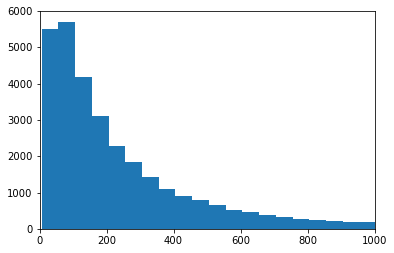

In [12]:
plt.hist([len(x) for x in train.comment_text], 100)
plt.xlim([0,1000])
plt.show()

## Text data preprocessing

In [13]:
import re
from nltk import RegexpTokenizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [14]:
targets = np.array(train.iloc[:,2:8])
print(targets)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ..., 
 [1 0 1 0 0 0]
 [1 0 1 0 1 0]
 [1 1 1 0 1 0]]


In [15]:
def punctuation_fix(sentence):
    sentence = re.sub(r"[^a-zA-Z]", " ", sentence).strip()
    return sentence

In [16]:
def preprocess(txt):
    return punctuation_fix(txt.lower())

In [17]:
docs = list(train.comment_text.values)

In [18]:
docs = list(map(preprocess, docs))

Let's see on random data rows what is the outcome of our preprocessing so far:

In [19]:
for i in np.random.randint(len(train.comment_text),size=5):
    print(train.comment_text.iloc[i])
    print("--")
    print(docs[i])
    print("*"*10)

"
Hilarious even without the en-dash thing: I keep reading Post-Hotree–Fuck.  (talk) "
--
hilarious even without the en dash thing  i keep reading post hotree fuck    talk
**********
I AM ENGLISH I AM! I DO NOT WANT TO GET BLOCKED AGAIN, FU@K!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
--
i am english i am  i do not want to get blocked again  fu k
**********
Way out of line? 

Out of line? Am I your subordinate? Do I exist only to be controlled by bigots like you? Right-wing prat
--
way out of line    out of line  am i your subordinate  do i exist only to be controlled by bigots like you  right wing prat
**********
"
Amazing how you could consider what you warned me first about as personal attack. Have you seen the person in questions User page and Talk page? Have you seen the violent rhetoric they had on there talk page until only recently? And your first warning was completely informal to boot. ""in some situations""? So how does this qualify as an exceptional situation? It does not. And

In [20]:
docs = list(map(nltk.word_tokenize, docs))

### Stopwrods

In [21]:
stop = set(stopwords.words('english'))
list(stop)[:10]

['myself',
 'where',
 'that',
 'same',
 'few',
 'before',
 'ourselves',
 'those',
 'needn',
 'this']

In [22]:
docs = list(map(lambda x: [i for i in x if i not in stop], docs))

## Lemmatizer 

In [23]:
wordnet_lemmatizer = WordNetLemmatizer()

In [24]:
docs = list(map(lambda x: " ".join(list(map(wordnet_lemmatizer.lemmatize, x))), docs))

## Word tokenizer

In [25]:
from keras.preprocessing.text import Tokenizer

In [26]:
num_words = 2000
tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
tokenizer.fit_on_texts(docs)
numdocs = tokenizer.texts_to_sequences(docs)

In [27]:
docs[3]

'mousercise title several disney production granted yes link photo intended particular entry album tv show video respectively course stupid bot would know suggest human review data personally talk shared ip address make edit please ignore notice well image wikipedia included img img tag forum rather using syntax also actually uploaded wikipedia server via wikipedia upload call people hole edit summary violates policy personal attack veinor talk know add use entry reverting instead needed starting piss talk last warning continue make personal attack blocked disruption ed edgar last warning try warning talk said call people hole edit summary violates policy personal attack read fault also showed paragraph upload image want help ask veinor talk must logged upload file word sign add thing entry hell place rot care talk regular damned lazy add photo instead want force others go bullshit signing add thing one entry f signing shit take site shove sun shine go hell'

In [28]:
numdocs[3]

[306,
 372,
 256,
 66,
 688,
 1677,
 711,
 504,
 1017,
 825,
 179,
 762,
 355,
 75,
 484,
 12,
 9,
 426,
 548,
 384,
 909,
 814,
 6,
 1495,
 168,
 328,
 25,
 27,
 11,
 995,
 375,
 43,
 52,
 3,
 538,
 180,
 868,
 249,
 184,
 24,
 158,
 829,
 3,
 1412,
 3,
 1761,
 236,
 15,
 1105,
 27,
 458,
 146,
 125,
 132,
 6,
 9,
 119,
 34,
 504,
 505,
 264,
 658,
 1362,
 905,
 6,
 193,
 220,
 234,
 25,
 125,
 132,
 85,
 848,
 193,
 220,
 182,
 220,
 6,
 83,
 236,
 15,
 1105,
 27,
 458,
 146,
 125,
 132,
 90,
 1811,
 24,
 589,
 1761,
 52,
 31,
 73,
 202,
 6,
 163,
 1640,
 1761,
 432,
 103,
 439,
 119,
 44,
 504,
 189,
 122,
 131,
 6,
 1622,
 119,
 688,
 264,
 31,
 717,
 210,
 13,
 123,
 119,
 44,
 7,
 504,
 192,
 17,
 57,
 137,
 1968,
 13,
 189]

In [29]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Embedding,Dropout, Conv1D, MaxPooling1D, BatchNormalization

In [30]:
maxlen = 40
numdocs_train = pad_sequences(sequences = numdocs, maxlen = maxlen)

In [31]:
numdocs_train[:3]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,  803,   50,   90,   83],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  104,
        1122,  784,  384,    1,   57,  131,    6],
       [1791,   11,  119,  317,   79,  188,  173,    1,    6,    4,  974,
         482,   11,  196,  305,   87,  180, 1694,  119,   53,    1,   12,
          73,   25, 1375,   43,  303,  436, 1356,  258,   23,    1, 1394,
         165,  152,  188,  173,    6,    4,   81]], dtype=int32)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(numdocs_train, targets, test_size=0.1)

In [33]:
type(X_train)

numpy.ndarray

In [34]:
embedding_vecor_length = 15

In [35]:
X_train.shape

(29205, 40)

## GRU

In [36]:
model = Sequential()
model.add(Embedding(num_words, embedding_vecor_length, input_length=maxlen))
model.add(Dropout(0.4))
model.add(GRU(20))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 15)            30000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 15)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20)                2160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 126       
Total params: 32,286
Trainable params: 32,286
Non-trainable params: 0
_________________________________________________________________
None


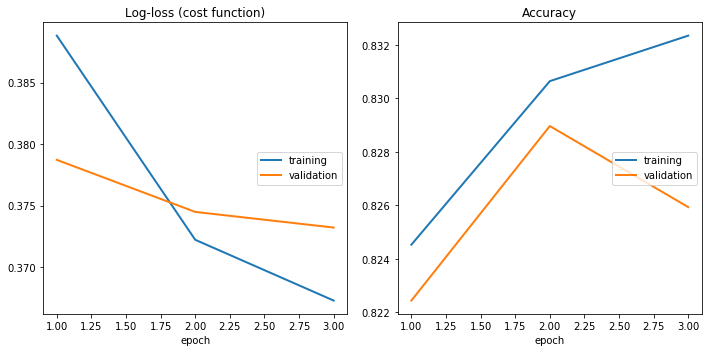

29205/29205 [==============================] - 28s - loss: 0.3673 - acc: 0.8323 - val_loss: 0.3732 - val_acc: 0.8259
GRU training time 87.63596796989441


In [37]:
t0 = time.time()
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=3, batch_size=64, callbacks=[plot_losses])
print("GRU training time", time.time()-t0)

In [38]:
test_data = pd.read_csv('test.csv')

In [39]:
test_docs = list(test_data.comment_text.values)
test_docs = list(map(preprocess, test_docs))
test_docs = list(map(nltk.word_tokenize, test_docs))
test_docs = list(map(lambda x: [i for i in x if i not in stop], test_docs))
test_docs = list(map(lambda x: " ".join(list(map(wordnet_lemmatizer.lemmatize, x))), test_docs))

In [ ]:
num_words = 2000
tokenizer = Tokenizer(num_words=num_words, lower=False, filters='')
tokenizer.fit_on_texts(test_docs)
numdocs_tmp = tokenizer.texts_to_sequences(test_docs)
numdocs_test = pad_sequences(sequences = numdocs_tmp, maxlen = maxlen)

In [ ]:
model.predict(numdocs_test, verbose=0)

In [ ]:
lstm_pred = model.predict_proba(numdocs_test)

In [ ]:
lstm_pred

In [ ]:
 lstm_res = pd.DataFrame(lstm_pred,columns=train.columns[2:8])
    lstm_res['id'] = test_data['id']

In [ ]:
lstm_res.head()

In [ ]:
lstm_res = lstm_res[['id','toxic','severe_toxic','obscene','threat', 'insult' ,'identity_hate']]

In [ ]:
lstm_res.to_csv('lstm_res.csv',index=False)